Numerical modeling requires validation, validation and more validation! In my work for my PhD I had to model a multidegree of freedom vibration problem. However, for confidence in the results I also need to compare it with a single degree of freedom to see how well it fares. So what better chance to learn how to solve differential equations in Julia! In this post I am learning how to use the DifferentialEquations package to solve the second order ordinary differential equation to model a structural response to an explosion load.

***

To reproduce this Jupyter notebook you  can download the source from [my github page](https://github.com/NikStoyanov/portfolio/tree/master/content/post/2019-02-17-single-degree-of-freedom-oscillator). I have ran this with Julia 1.1 and for the dependencies you can use the project file in the repository. 

# The simple harmonic oscillator

To start things we look at a simple case of the simple harmonic oscillator. This can be represented by a frictionless cart with mass, $m$, that moves in one dimension, $x$, hence single degree of freedom (SDOF). An excitation force, $f(t)$, is applied and the model is balanced by the stiffness, $k$, and damping, $c$, of the cart and connection. Based on the properties different dynamic phenomena can be observed. A graphical representation of this problem can be seen below.

<img src="sdof.svg" />

Written mathematically the above is expressed in Equation 1.

$$
\begin{equation}
m \frac{d^2 x}{d t^2} + c \frac{d x}{d t} + k x = f(t)
\end{equation}
$$

This is a non-homogeneous second order ordinary differential equation with constant coefficients (whew that was long). To solve it we can reduce it to a first order differential equation. We can do this by writing Equation 1 as the system shown below with the idea that the time derivative of the displacement is the speed, $v$.

$$
\begin{align*}
\dot{x} &= v\\
\dot{v} &= \frac{1}{m}(-cv -kx + f(t))
\end{align*}
$$

Using $\text{DifferentialEquations}$ we can solve the ODE. I am also using the $\text{DiffEqCallbacks}$ package to call custom functions in order to implement the excitation force, $f(t)$ and $\text{ParameterizedFunctions}$ to write the problem using the $\text{@ode_def}$ macro. This allows me to write the equation in almost the same way as I have written it mathematically.

In [466]:
using Plots
using DiffEqCallbacks
using DifferentialEquations
using ParameterizedFunctions

In [467]:
g = @ode_def begin
    dx = v
    dv = (-c * v - k * x - p) / m
end c k p m

#514 (generic function with 2 methods)

Here we set the  damping, $c=0.1$, stiffness, $k=10$, initial force, $p=1$ and mass, $m=1$. The initial conditions are  speed, $v=0$ and displacement, $x=1$. We are also running the simulation for a time, $t=100$.

In [468]:
tspan = (0.0, 100.0)
x0 = [0.; 1.0]
p = [0.1, 10.0, 1.0, 1.0];

Next we need to define the callback functions. The idea is that at every time step $\Delta t$ the functions will be called and update the excitation force. In $\text{DiffEqCallbacks}$ this is done using a condition i.e. what causes the event and what effect it has. In our model we can use a simple condition function to always return true and the affect is to mutate the parameter $p$. In this case I will leave the initial conditions to dampen out and at the 60 second mark a new excitation force will be applied.

In [469]:
function condition(x, t, integrator)
    true
end

function affect!(integrator)
    if integrator.t > 60
        integrator.p[3] = 10.
    else
        integrator.p[3] = 1.
    end
end

cb = DiscreteCallback(condition, affect!);

Our problem is not stiff so we can use the $\text{Tsit5}$ solver. This is the Tsitouras 5/4 Runge-Kutta method and is the generally recommended method.

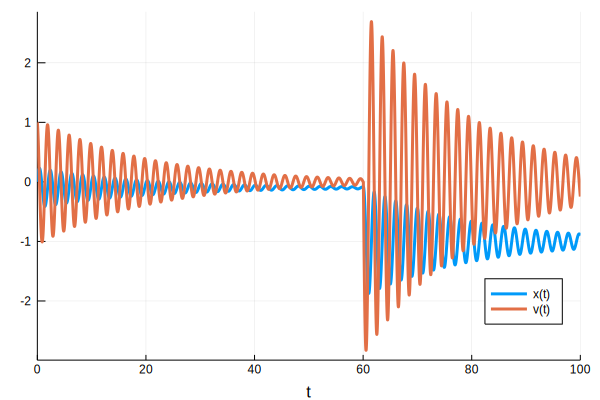

In [470]:
prob = ODEProblem(g, x0, tspan, p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, callback = cb)
plot(sol, legend=:bottomright, format=:svg)

As expected the initial conditions dampen until the 60 second mark when the next excitation force starts a new cycle.

# Beam under explosion load

For the next part we need to solve more complicated problems. In particular for my application I need to model a simply supported beam with a uniform load which represents an explosion. To use the SDOF formulation we need to collate the structural and material properties into one dimension. The problem we are modeling can be shown graphically below.

<img src="beam.png" />

We can assume that the Young's modulus is $200 \ \text{GPa}$, the second moment of area $4 \times 10^{-3} m^4$, the mass per unit length $129 \ \text{kg/m}$ and the length $4 \ \text{m}$. The properties are for a 4 meter long column with serial size 356x368x129. This is specifically chosen to compare my results with [this paper](https://www.sciencedirect.com/science/article/pii/S0143974X07001976).

In [319]:
E = 200*10^9.
I = 4 *10^(-3)
m = 129.
L = 4.;

To solve the problem we can use the Rayleigh-Ritz method. The idea is to reduce the continuous system to a discrete multi-degree of freedom model by assuming deformation shapes. The degree of freedom is determined by the number of assumed shapes, also known as modes. The fundamental mode for our case is shown in Equation 2. It can easily be checked that the mode complies to the boundary conditions i.e. zero at both ends and the beam would follow $\pi \ \text{rad}$ of a sinusoid.

$$
\begin{equation}
\phi(x) = sin \left( \frac{\pi x}{L} \right)
\end{equation}
$$

To represent visually what I mean by the above we can assume that our beam follows the curve below and we need to scale our ODE to do the same.

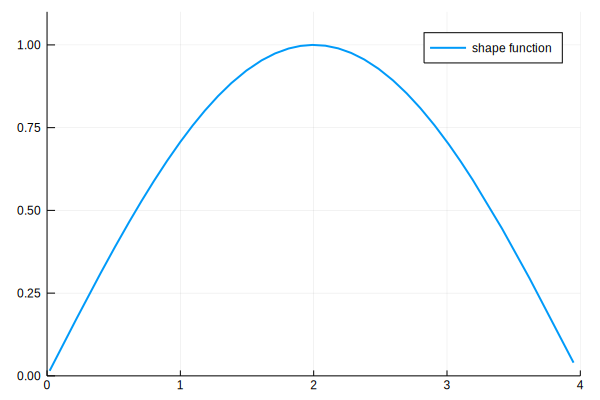

In [401]:
shape(x) = sin(π*x/L)
plot(shape, 0., 4., label="shape function", format=:svg, width=2, xlims=(0., 4.), ylims=(0., 1.1))

Hence, we need to modify the constants in Equation 1 to scale with the shape function. Also for the case of investigating a blast load the duration is too short and damping can be neglected, hence we are going to omit the $c$ term and balance only with mass and stiffness. Therefore, the modified Equation 1 is now becomes Equation 3.

$$
\begin{equation}
\bar{m} \frac{\partial^2 y}{\partial t^2} + \bar{k} y = \bar{f}(t)
\end{equation}
$$

Where each of the modified constants is given below in Equation 4, 5 and 6.

First lets do the excitation force. We assume the same conditions as the paper for validation purposes. So a blast load of 5.42 MPa is applied to one of the flanges of the beam for 15 ms with a linearly decreasing magnitude.

In [432]:
function blast_load(t::Float64)
    if t <= 0.015
        return 5.42 * 0.3686 * 10^6 * (0.015 - t) / 0.015
    else
        return 0.
    end
end

blast_load (generic function with 1 method)

Having defined the blast load we need to calculate the excitation force given in Equation 4.

$$
\begin{equation}
\bar{f}(t) = \int_0^L q(t) \phi(x) dx
\end{equation}
$$

In [433]:
int_shapef = L / π

function excitation_force(t::Float64)
    q = blast_load(t)
    return q * int_shapef
end

excitation_force (generic function with 1 method)

We need to repeat the same procedure for the mass and stiffness values given in Equation 5 and 6 respectively.

$$
\begin{equation}
\bar{m} = \int_0^L m \phi (x)^2 dx
\end{equation}
$$

In [434]:
int_sq_shapef = L / 2

function dist_mass()
    return m * int_sq_shapef
end

dist_mass (generic function with 1 method)

$$
\begin{equation}
\bar{k} = \int_0^L EI \frac{d^2 \phi}{d x^2} ^2 dx
\end{equation}
$$

Well okay this required me to remember my calculus class. But again it is quite straightforward.

In [435]:
int_twice_sq_shapef = π^4 / (2*L^3)

function dist_stiff()
    return 0.08*E*I*int_twice_sq_shapef
end

dist_stiff (generic function with 1 method)

We can now re-define our ODE without damping.

In [471]:
f = @ode_def begin
    dx = v
    dv = (- k * x + p) / m
    end k p m

#516 (generic function with 2 methods)

Next we need to define the computation of the constants to be done on every timestep. Note that the value of $\bar{m}$ is constant and for an elastic case $\bar{k}$ does not change as well.

In [437]:
function condition(x, t, integrator)
    true
end

function affect!(integrator)
    integrator.p[2] = excitation_force(integrator.t)
end

cb = DiscreteCallback(condition, affect!);

As a quick check we can calculate the natural period of the structure.

In [438]:
mbar = dist_mass()
kbar = dist_stiff()
ω = sqrt(kbar/mbar)
"Period, s", 2*π/ω, "Frequency, Hz", ω/(2*π)

("Angular Freq, rad/s", 434.4851070007246, "Period, s", 0.01446122135359891, "Freq, Hz", 69.15045247897639)

The values are consistent with what I am expecting. We can then define out initial conditions and solve the problem.

In [452]:
tspan = (0.0, 0.1)
x0 = [0.; 0.]
p = [kbar, excitation_force(0.), mbar]

prob = ODEProblem(f, x0, tspan, p)
sol = solve(prob, Tsit5(), callback = cb);

And plot the solution with the validation case.

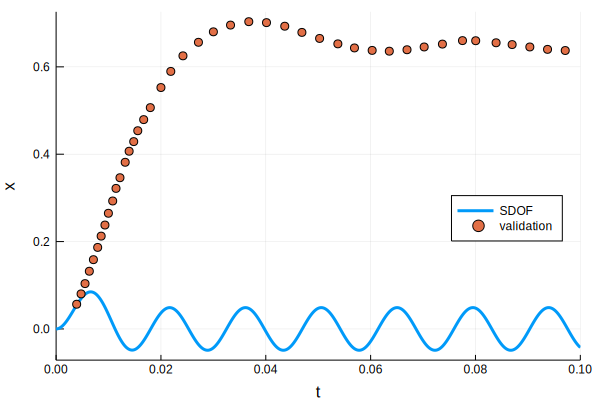

In [453]:
using CSV
validation = CSV.read("Liew_2007_Fig2.csv")
plot(sol, vars=(:t, :x), label="SDOF")
scatter!(validation[1], validation[2], label="validation", format=:svg, legend=:right)

Huh... I wish I could say the results are great. But we can see that the elastic behaviour is captured, so there is hope! In all honesty this was to be expected, in the end we have modeled a purely elastic structure and when the differential equation reaches a balance the only way to continue is for the structure to swing in the other direction which is evident at about 0.005s. With the lack of damping the structure continues to oscillate. This means we need to allow for energy to be dissipated somehow - we need a strain rate dependent plastic model.

To illustrate, if we can calculate the strains and stresses to determine that the structure has become plastic then we can remove the stiffness. Below is an example where we arbitrary do this at the 0.005s mark.

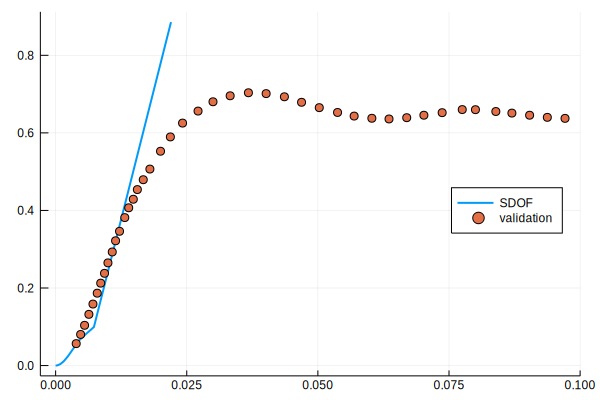

In [465]:
k = @ode_def begin
    dx = v
    dv = (- k * x + p) / m
    end k p m

function condition(x, t, integrator)
    true
end

function affect!(integrator)
    integrator.p[2] = excitation_force(integrator.t)
    
    if integrator.t > 0.005
        integrator.p[1] = 0
    end
end

cb = DiscreteCallback(condition, affect!)

tspan = (0.0, 0.1)
x0 = [0.; 0.]
p = [kbar, excitation_force(0.), mbar]

prob = ODEProblem(k, x0, tspan, p)
sol = solve(prob, Tsit5(), callback = cb)

plot(sol.t[1:21], sol[1, 1:21], width=2, label="SDOF")
scatter!(validation[1], validation[2], label="validation", format=:svg, legend=:right)

And as expected the behaviour is much closer approximated. In fact this highlights the need to add a strain rate dependent plastic model to the calculation but this is work for another post. Thanks for reading!